# Unit 2: Autograd

Tất cả mọi thứ liên quan đến bài toán ML từ load dữ liệu, tham số của model, output đều là tensor.

## Requires_grad
Để pytorch lưu và tính toán đạo hàm của 1 tensor, mình gán thuộc tính `requires_grad = True` cho tensor đó và Pytorch chỉ cho phép float tensor được gán thuộc tính `requires_grad = True`.

Bài trước khi mình khởi tạo tensor thì mặc định `requires_grad = False`.

In [1]:
import torch

In [2]:
a = torch.tensor([2., 3.])
a.requires_grad # False

False

In [3]:
# Gán thuộc tính requires_grad = True
a = torch.tensor([2., 3.], requires_grad=True)
a.requires_grad

# Or
a = torch.tensor([2., 3.], requires_grad=True)
a.requires_grad = True

Thuộc tính `requires_grad` lây lan, tức là nếu a có `requires_grad=True`, thì các tensor khác được tính toán từ a, cũng sẽ có `requires_grad=True`.

In [4]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([1., 1.])

print(a.requires_grad) # True
print(b.requires_grad) # False

c = a + b # [3., 4.]
print(c.requires_grad) # True

True
False
True


Khi tensor có `requires_grad`, Pytorch sẽ xây `computational graph`.

In [5]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = z**2

Giả sử `a`, `b` là tham số của model, `L` là loss function. Giờ mình tính đạo hàm của `L` với `a`, `b` để thực hiện thuật toán gradient descent.
![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-23.png?resize=768%2C393&ssl=1)

Những tensor màu đỏ có thuộc tính `requires_grad = True`, còn màu đen thì `requires_grad = False`. Những tensor được khoanh bởi hình tròn màu xanh lá cây được gọi là `leaf tensor`. `Leaf tensor` là những tensor do mình khởi tạo, chứ không phải do mình tạo ra trong quá trình tính toán như `y_hat`, `z`.

In [6]:
print(x.is_leaf) # True
print(a.is_leaf) # True
print(y_hat.is_leaf) # False
print(L.is_leaf) # False

True
True
False
False


**Nhận xét**: trong mô hình neural network thì tất cả các weight, bias đều là leaf tensor.

Trong Pytorch, để tính đạo hàm `L` với `a`, `b`, mình gọi hàm.

In [7]:
L.backward()

Khi đó Pyotrch sẽ tính đạo hàm của `L` với các `leaf tensor` có thuộc tính `requires_grad = True` và lưu vào thuộc tính grad của tensor. Để tính đạo hàm ngược lại thì Pytorch cũng dùng chain rule để tính.
![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-24.png?resize=768%2C318&ssl=1)

In [8]:
print(x.grad) # None
print(y.grad) # None
print(a.grad) 
print(b.grad)

None
None
tensor([-30.])
tensor([-10.])


## Function
Pytorch tính đạo hàm ngược cho chain rule như thế nào?

Các tensor *không phải* leaf node và có `autograd = True` sẽ có thuộc tính `grad_fn` để lưu lại phép tính thực hiện ở bước đấy, để tính chain rule ngược lại.

In [9]:
print(x.grad_fn.__class__.__name__) # None
print(a.grad_fn.__class__.__name__) # None
print(y_hat.grad_fn.__class__.__name__) # AddBackward0 
print(z.grad_fn.__class__.__name__) # SubBackward0 
print(L.grad_fn.__class__.__name__) # PowBackward0

NoneType
NoneType
AddBackward0
SubBackward0
PowBackward0


Mình có thể dùng thư viện `torchviz` để visualize computational graph trong Pytorch.

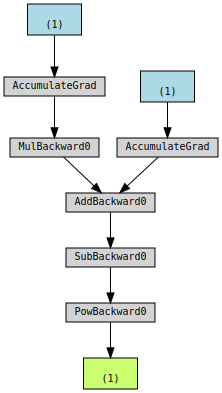

In [10]:
from torchviz import make_dot
make_dot(L)

Các class `MulBackward`, `AddBackward`, `SubBackward`, `PowBackward` đều được kế thừa từ `torch.nn.Autograd.Function`, trong đó có 2 hàm quan trọng:

- `def forward(ctx, input)`: nhận các `tensor inputs`, và trả về tensor output. Biến `ctx` để lưu lại các tensor cần thiết trong quá trình `backward` (chain rule).
- `def backward(ctx, grad_output)`: `grad_output` chứa đạo hàm của loss đến tensor ở node đấy, `ctx` lấy các giá trị lưu ở hàm forward để tính đạo hàm ngược qua node đó.

Ví dụ: mình có thể custom hàm bình phương như thế này.

In [11]:
class MySquare(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input**2

    @staticmethod
    def backward(ctx, grad_outputs):
        input, = ctx.saved_tensors
        return 2*input*grad_outputs

# Call function as alias 
my_square = MySquare.apply

# Xay lai graph
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)

y_hat = a*x + b
z = y_hat - y
L = my_square(z)


![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-26.png?w=474&ssl=1)

Và nếu mình tính backward ngược lại thì kết quả ra giống ở trên

In [12]:
L.backward()
print(a.grad) # -30
print(b.grad) # -10

tensor([-30.])
tensor([-10.])


Trong trường hợp tổng quát, hàm `forward` tính xuôi bình thường, còn hàm `backward` sẽ có dạng như thế này:

In [13]:
def backward (ctx, grad_output):
        # thuộc tính grad chỉ cần thiết nếu ở leaf tensor.
	self.Tensor.grad = grad_output

        # duyệt qua các input đến node này để trả đạo hàm ngược lại.
	for inp in self.inputs:
		if inp.grad_fn is not None:
                        # local_grad là đạo hàm trong node đang tính
			new_incoming_gradients = grad_output * local_grad(self.Tensor, inp)
			
			inp.grad_fn.backward(new_incoming_gradients)
		else:
			pass

## Backward
Nếu mọi người gọi hàm backward với vector Tensor thì Pytorch sẽ báo lỗi.

In [14]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
# y.backward() # RuntimeError: grad can be implicitly created only for scalar outputs

Mọi người thấy nó báo lỗi là chỉ `backward` được với 1 số thực thôi, thực ra cũng hợp lý vì *loss function* của mình cũng là 1 số thôi, nên hàm mặc định Pytorch chỉ hỗ trợ mọi người `backward` lại với 1 số thực.

In [15]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x +1
z = sum(y)
z.backward()

print(x.grad) # 2, 2, 2

tensor([2., 2., 2.])


![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-27.png?resize=768%2C358&ssl=1)

Đạo hàm số thực với vector

Mình tạm quy ước với nhau theo sách *Math for Machine Learning*, `vector` sẽ viết dạng cột. Còn hàm `f` từ 1 `vector (x)` sang 1 số thực, thì đạo hàm `f` với `x` sẽ là 1 `vector` dạng hàng. Như trong ví dụ trên:

![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-29.png?resize=768%2C357&ssl=1)

Còn về chuyện đạo hàm của 1 vector với input là vector, output sẽ là 1 Jacobian matrix.

Còn về chuyện đạo hàm của 1 vector với input là vector, output sẽ là 1 Jacobian matrix.
![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-30.png?resize=768%2C458&ssl=1)

Jacobian matrix


Pytorch cũng hỗ trợ mọi người tính `backward` lại với tensor vector qua thuộc tính `gradient`, với ý nghĩa `gradient` ở đây được giả định là đạo hàm của *loss function* với tensor đang gọi `backward`.

![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-31.png?resize=1024%2C465&ssl=1)

Mọi người thấy, khi gọi `y.backward` mình truyền 1 vector `tensor` có kích thước bằng kích thước của y, ý nghĩa có thể hiểu đó chính là đạo hàm của `loss` với `y`.

In [16]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
y.backward(gradient=torch.tensor([1, 2, 1]))

print(x.grad) # 2, 4, 2

tensor([2., 4., 2.])


![](https://i0.wp.com/nttuan8.com/wp-content/uploads/2021/03/image-33.png?resize=768%2C455&ssl=1)

## Dynamic Computation Graph
Pytorch chỉ build *computational graph* khi hàm `forward` của tensor được gọi khi chạy chương trình.

In [17]:
x = torch.tensor([1., 2., 3.], requires_grad=True) # graph chưa được tạo
y = 2*x + 1 # bắt đầu tạo graph khi chạy qua dòng này

Khi tạo graph các `non-leaf node` (tensor) được cấp phát bộ nhớ, context (ctx) được tạo để lưu các biến tạm cho quá trình `backward`. Sau đó, khi mình gọi `backward`, thì đạo hàm được tính ngược lại cho các `leaf tensor` và sau đó graph bị hủy, vùng nhớ lưu các `non-leaf node`, biến tạm trong context được giải phóng. Do đó mình không thể backward 2 lần liên tiếp.

In [18]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)
z.backward()
print(x.grad) # tensor([2., 2., 2.])
# z.backward() # RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

tensor([2., 2., 2.])


Tuy nhiên khi train model DL, mình cần train nhiều epoch, mỗi epoch lại có nhiều step, nên mình cần gọi backward nhiều lần để tính đạo hàm ngược lại. Để thực hiện backward nhiều lần mình cần để thuộc tính `retain_graph = True`.

In [19]:
# loss.backward(retain_graph=True)

Tuy nhiên khi mình `backward` nhiều lần thì đạo hàm sẽ cộng dồn vào `leaf tensor`.

In [20]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = 2*x + 1
z = sum(y)
z.backward(retain_graph=True)
print(x.grad) # 2, 2, 2
z.backward(retain_graph=True)
print(x.grad) # 4, 4, 4
z.backward(retain_graph=True)
print(x.grad) # 6, 6, 6

tensor([2., 2., 2.])
tensor([4., 4., 4.])
tensor([6., 6., 6.])


Thế nên khi ở mỗi step dùng `gradient descent` xong mình thường `zero_grad` trước khi sang step khác.

Pytorch xây **Dynamic Computation Graph** khi chạy chương trình khi qua hàm `forward` của `non-leaf tensor`, còn Tensorflow 1.x xây **Static Computation Graphs**, tức là Graph được xây trước, sau đó graph được chạy bằng cách “feed” giá trị vào các placeholder.

Với **Dynamic Computation Graph**, mình có thể thay đổi kiến trúc khi chạy chương trình. Do đó quá trình debug sẽ đơn giản hơn. Ở Tensorflow 2.x cũng sử dụng **Dynamic Computation Graph**, chi tiết mọi người xem thêm ở [đây](https://cs230.stanford.edu/section/5/).

## Tips
### Requires_grad = False
Trong quá trình chạy mình cũng có thể gán `requires_grad = False` cho tensor, ví dụ để `freeze` một vài layers không cập nhật hệ số, khi đó tensor sẽ không tham gia vào computation graph.

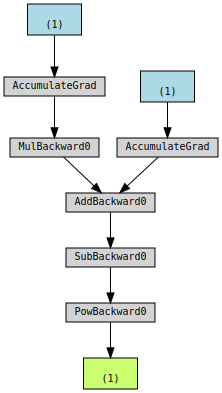

In [21]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)
c = a*x
y_hat = c + b
z = y_hat - y
L = z**2
make_dot(L)

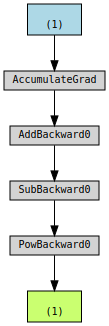

In [22]:
x = torch.tensor([3])
y = torch.tensor([10])
a = torch.tensor([1.], requires_grad=True)
a.requires_grad = False
b = torch.tensor([2.], requires_grad=True)
c = a*x
y_hat = c + b
z = y_hat - y
L = z**2
make_dot(L)

### torch.no_grad()
Trong quá trình inference thì mình không cần đạo hàm ngược lại nên không cần lưu giá trị biến tạm ở các node, mà đơn giản chỉ tính forward bình thường. Pytorch hỗ trợ context manager `torch.no_grad` cho việc này, khi nào mọi người không cần dùng backward thì hãy dùng `torch.no_grad` để giảm thiểu bộ nhớ và tính toán. Hay hiểu đơn giản hơn thì trong context của `torch.no_grad` thì tất cả các tensor có thuộc tính `requires_grad = False`.


In [24]:
# with torch.no_grad:
# 	#inference code goes here 
#     pass

AttributeError: __enter__

### Áp dụng Autograd cho bài toán linear regression
Mình sẽ dùng dữ liệu nhà ở trên để chạy thuật toán linear regression với Pytorch

Đầu tiên mình sẽ load dữ liệu

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# load dữ liệu, chuyển về dạng numpy
# data = pd.read_csv('data_linear.csv').values
noise = torch.randn(20)

# chuyển dữ liệu về dạng torch
x = torch.arange(20)+noise
y = 2 * x + 3

In [45]:
# hàm model f(x) = ax+b
def model(x: torch.Tensor, a: torch.Tensor, b: torch.Tensor):
    return a * x + b

In [60]:
# hàm loss function, Mean Squared Error
def loss_fn(y_hat: torch.Tensor, y: torch.Tensor):
    squared_diffs = (y_hat - y)**2
    return torch.mean(squared_diffs)

In [90]:
# Training function 
def training_loop(n_epochs, learning_rate, params, x, y):
    a = torch.tensor(params[0], requires_grad = True)
    b = torch.tensor(params[1], requires_grad = True)
    ## Save loss in the epochs to show loss graph
    losses = []
    for epoch in range(1, n_epochs + 1):
        # If have grad in a, b params, make zero, avoid cumulative grad
        if a.grad is not None:
            a.grad.zero_()
        if b.grad is not None:
            b.grad.zero_()

        # Call model and loss
        y_hat = model(x, a, b)
        loss = loss_fn(y_hat, y)
        # loss.requires_grad = True

        # Call callback to compute back propagation of loss with a, b params
        loss.backward()

        # Update a, b with GD algorithm, if torch.no_grad, we dont need to backward in the step
        with torch.no_grad():
            a -= learning_rate * a.grad
            b -= learning_rate * b.grad
        
        if epoch % 1 == 0:
            #save loss 
            losses.append(loss.item())
            print('Epoch = %d, Loss = %f' %(epoch, float(loss)))
        
    return a, b, losses




a, b, losses = training_loop(10000, 1e-3, [0., 0.], x, y)
print('\nResult: y = %fx + %f' %(float(a), float(b)))

Epoch = 1, Loss = 638.955444
Epoch = 2, Loss = 351.832642
Epoch = 3, Loss = 194.204117
Epoch = 4, Loss = 107.666527
Epoch = 5, Loss = 60.157116
Epoch = 6, Loss = 34.073750
Epoch = 7, Loss = 19.753046
Epoch = 8, Loss = 11.889921
Epoch = 9, Loss = 7.571935
Epoch = 10, Loss = 5.200210
Epoch = 11, Loss = 3.896947
Epoch = 12, Loss = 3.180259
Epoch = 13, Loss = 2.785605
Epoch = 14, Loss = 2.567737
Epoch = 15, Loss = 2.446929
Epoch = 16, Loss = 2.379405
Epoch = 17, Loss = 2.341136
Epoch = 18, Loss = 2.318929
Epoch = 19, Loss = 2.305540
Epoch = 20, Loss = 2.296995
Epoch = 21, Loss = 2.291110
Epoch = 22, Loss = 2.286685
Epoch = 23, Loss = 2.283067
Epoch = 24, Loss = 2.279890
Epoch = 25, Loss = 2.276957
Epoch = 26, Loss = 2.274161
Epoch = 27, Loss = 2.271440
Epoch = 28, Loss = 2.268761
Epoch = 29, Loss = 2.266108
Epoch = 30, Loss = 2.263470
Epoch = 31, Loss = 2.260840
Epoch = 32, Loss = 2.258220
Epoch = 33, Loss = 2.255603
Epoch = 34, Loss = 2.252990
Epoch = 35, Loss = 2.250381
Epoch = 36, Loss 

In [86]:
# Dự đoán giá trị mới, x = 50
x_test = torch.tensor(15)
with torch.no_grad():
    y_hat = model(x_test, a, b)
    print(y_hat)

tensor(33.0010)
